https://docs.fast.ai/tutorial.vision.html

In [1]:
from fastai.vision.all import *

In [10]:
path = untar_data(URLs.PETS)

In [11]:
path.ls()

(#2) [Path('/Users/home/.fastai/data/oxford-iiit-pet/images'),Path('/Users/home/.fastai/data/oxford-iiit-pet/annotations')]

In [12]:
files = get_image_files(path/"images")
len(files)

7390

In [13]:
files[0],files[6]

(Path('/Users/home/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_167.jpg'),
 Path('/Users/home/.fastai/data/oxford-iiit-pet/images/Birman_167.jpg'))

In [14]:
def label_func(f): return f[0].isupper()

In [15]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

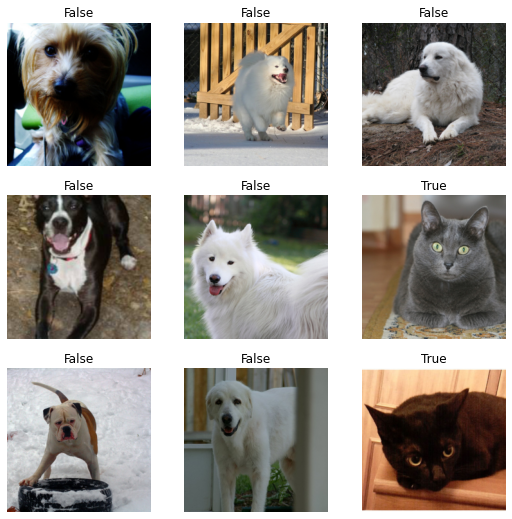

In [16]:
dls.show_batch()

In [18]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
# learn.fine_tune(1)

In [19]:
learn.predict(files[0])

('True', TensorBase(1), TensorBase([0.0723, 0.9277]))

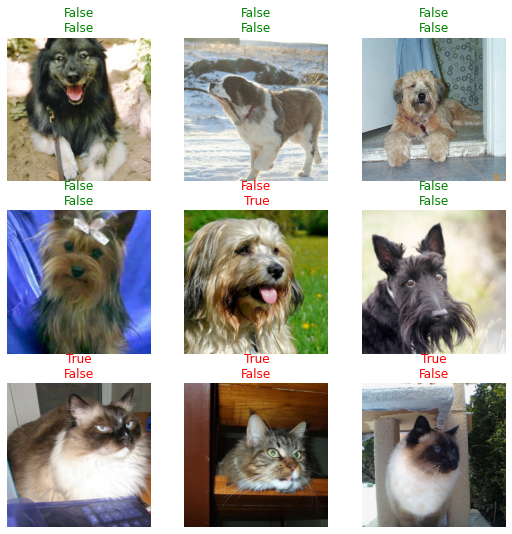

In [20]:
learn.show_results()

## Classifying breeds

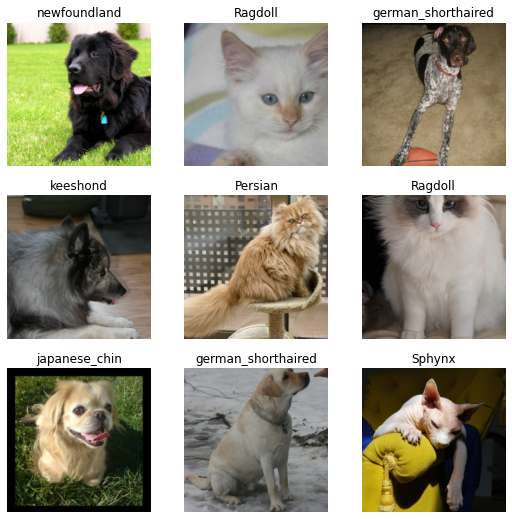

In [21]:
pat = r'^(.*)_\d+.jpg'
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))
dls.show_batch()

In [22]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

/Users/home/bin/anaconda3/envs/py37/lib/python3.7/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


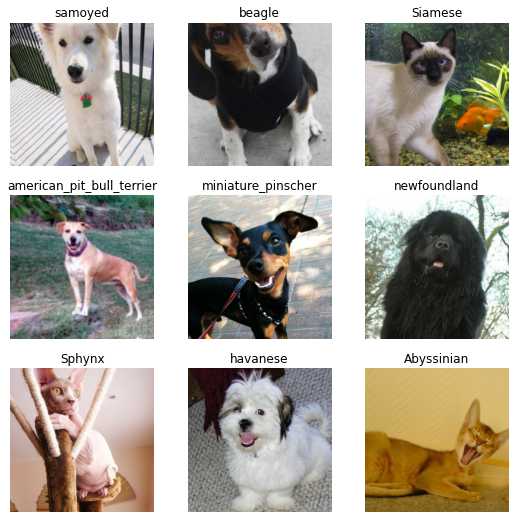

In [23]:
dls.show_batch()

In [24]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [ ]:
learn.lr_find()

[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:214] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

In [ ]:
learn.fine_tune(2, 3e-3)

In [ ]:
learn.show_results()

In [ ]:
interp = Interpretation.from_learner(learn)

interp.plot_top_losses(9, figsize=(15,10))

Single-label classification - With the data block API

In [ ]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))

In [ ]:
dls = pets.dataloaders(untar_data(URLs.PETS)/"images")
dls.show_batch(max_n=9)

# Multi-label classification

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

In [ ]:
dls.show_batch()

Training a model is as easy as before: the same functions can be applied and the fastai library will automatically detect that we are in a multi-label problem, thus picking the right loss function. The only difference is in the metric we pass: error_rate will not work for a multi-label problem, but we can use accuracy_thresh.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))
learn.lr_find()

In [ ]:
learn.fine_tune(2, 3e-2)

In [ ]:
learn.show_results()

In [ ]:
learn.predict(path/'train/000005.jpg')

As for the single classification predictions, we get three things. The last one is the prediction of the model on each class (going from 0 to 1). The second to last cooresponds to a one-hot encoded targets (you get True for all predicted classes, the ones that get a probability > 0.5) and the first is the decoded, readable version.

And like before, we can check where the model did its worse:


In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)

In [5]:
df.head()

NameError: name 'df' is not defined

In [ ]:
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter('is_valid'),
                   get_x=ColReader('fname', pref=str(path/'train') + os.path.sep),
                   get_y=ColReader('labels', label_delim=' '),
                   item_tfms = Resize(460),
                   batch_tfms=aug_transforms(size=224))

In [ ]:
dls = pascal.dataloaders(df)

In [ ]:
dls.show_batch(max_n=9)

# Segmentation

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
path.ls()

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

In [ ]:
fnames = get_image_files(path/"images")
fnames[0]

In [ ]:
(path/"labels").ls()[0]

In [ ]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

In [ ]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = fnames, label_func = label_func, codes = codes
)

In [ ]:
dls.show_batch(max_n=6)

In [ ]:
learn = unet_learner(dls, resnet34)
learn.fine_tune(6)

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

In [ ]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=3)

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [ ]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   batch_tfms=aug_transforms(size=(120,160)))

In [ ]:
dls.show_batch(max_n=6)